# Examen Práctico 

#### 3670 COM:01-3900 | Ciencia de datos | 2024 C2

Alumnos:

## Enunciado

Se tiene un dataset con datos del historial de solicitantes a quienes se le otorgaron créditos y su situación final como deudores o pagadores. La entidad tiene que determinar a quienes entregar o no un crédito en función de su propensión a caer en "default". Desarrolle un proceso que clasifique deudores y pagadores. Observe que la clase de interés es "default", y debido a nuevas políticas de encaje bancario se ha expresado el objetivo de evitar tanto como sea posible entregar créditos a deudores (a costa naturalmente de perder algún posible crédito a pagadores). Maximice la métrica correspondiente sin modificar threshold.

 Las columnas tienen nombres descriptivos, pero para mas información:

Importe: Cuando dinero esta pidiendo prestado</BR>
añosPago: Tiempo para pagar el crédito</BR>
IngresoAnuales: Ingresos anuales del solicitante</BR>
RelacionIngresoDeuda: Ratio entre sus ingresos y la deuda</BR>
RelacionCuotaDeuda: Ratio entre sus ingresos y la cuota</BR>
PendienteEnTarjeta: Pendiente de pago en tarjetas de crédito</BR>
UsoCreditoTarjeta: Volumen de dinero que maneja con sus instrumentos de crédito</BR>
Objetivo: ¿Para que quiere el préstamos?</BR>
esPropietario: ¿Es propietario del su casa?</BR>
FueVeraz: ¿Alguna vez estuvo en el veraz?</BR>
TuvoEmbargo: ¿Tuvo algun embargo o situación judicial?</BR>
Cuentas: Cantidad de cuentas que maneja</BR>
PuntuacionGeneral: Puntuación crediticia otorgada por un organismo regular</BR>
Default: Si pagó o no el crédito</BR>
AntiguedadLaboral: Antiguedad laboral</BR>

## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general. 

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR> 



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente, recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos. Ej: "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si EVALUACION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos).Puede dejar funcionando implementaciones alternativas que no prosperaron en notebooks separados. En cuanto comience con el desarrollo informe a los docentes el nombre del repositorio.


## Evaluacion final - Docente + Alumno

In [2]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Lectura de los datos

In [4]:
df = pd.read_csv(STUDENTDATAFILE)

In [49]:
class ColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean"), columns=None):
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self    
    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()
    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.imputer.transform(X[self.columns])
        return Xc
    
class ColumnDropNulls(BaseEstimator, TransformerMixin):
    def __init__(self, treshold=70):
        self.treshold = treshold
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        overseventy = (Xc.isnull().sum()/len(Xc)*100).where(lambda x: x > self.treshold).dropna()
        names = overseventy.index.tolist()
        for name in names:
            Xc.drop(columns=[name], inplace=True)
        return Xc

class ColumnDropUnique(BaseEstimator, TransformerMixin):
    def __init__(self, treshold=70):
        self.treshold = treshold
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        unique = (Xc.nunique()/len(Xc)*100).where(lambda x: x > self.treshold).dropna()
        names = unique.index.tolist()
        outputs = [Xc]
        print('DEBUG: ', names)
        for name in names:
            aux = outputs[-1]
            Xc.drop(columns=[name], inplace=True)

        return Xc

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        Xc.drop(columns=self.columns, inplace=True)
        return Xc

class ColumnOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=OneHotEncoder(drop='first', sparse_output=False), columns=None):
        self.encoder = encoder
        self.columns = columns

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out()
    
    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.encoder.get_feature_names_out()] = self.encoder.transform(Xc[self.columns])
        Xc.drop(columns=self.columns, inplace=True)
        return Xc

In [8]:
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


In [10]:
(df.isnull().sum()/len(df)*100)

Importe                 0.0
añosPago                0.0
IngresoAnuales          0.0
RelacionIngresoDeuda    0.0
RelacionCuotaDeuda      0.0
PendienteEnTarjeta      0.0
UsoCreditoTarjeta       0.0
Objetivo                0.0
esPropietario           0.0
FueVeraz                0.0
TuvoEmbargo             0.0
Cuentas                 0.0
PuntuacionGeneral       0.0
Default                 0.0
AntiguedadLaboral       0.0
dtype: float64

Calculamos la cantidad de valores unicos por columna, para detectar identificadores unicos que no aportan valor predictivo

In [11]:

(df.nunique()/len(df)*100)

Importe                  3.072987
añosPago                 0.005881
IngresoAnuales          12.465447
RelacionIngresoDeuda    10.127625
RelacionCuotaDeuda      89.925307
PendienteEnTarjeta      60.971593
UsoCreditoTarjeta        3.114156
Objetivo                 0.035288
esPropietario            0.011763
FueVeraz                 0.005881
TuvoEmbargo              0.005881
Cuentas                  0.138211
PuntuacionGeneral        0.102923
Default                  0.005881
AntiguedadLaboral        0.035288
dtype: float64

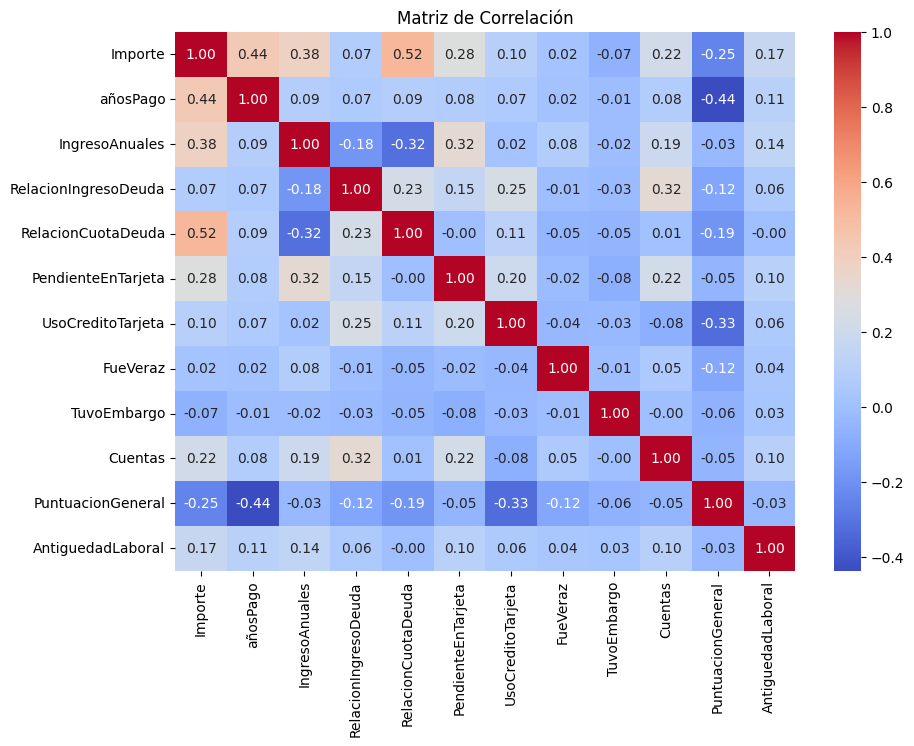

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
mat = df.select_dtypes(include=['int', 'float']).corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

<Axes: >

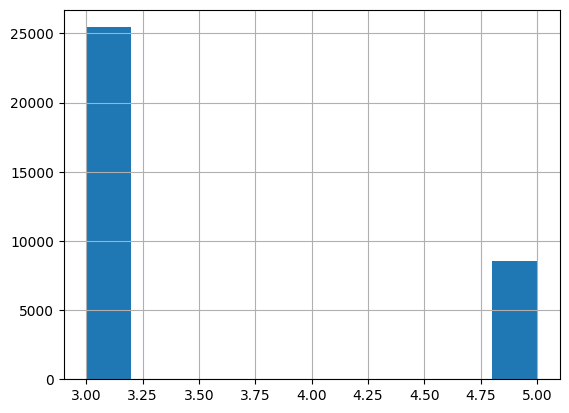

In [62]:
# Show histogram of IngresoAnuales
df['añosPago'].hist()

Procesamiento trivial solo para verificar funcionamiento de la plantilla.

In [63]:
# Atencion: Esto es un ejemplo solo para verificar que la plantilla funciona, remplazar.
X = df.drop(columns='Default')
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('SimpleImputacion', SimpleImputer(), ['añosPago', 'IngresoAnuales']),
#    ])
#Pipeline ejemplo
#pl = Pipeline([
#    ('preprocessor', preprocessor),
#    ('classifier', KNeighborsClassifier(n_neighbors=20))
#])
#pl.fit(X_train, y_train)
# Define preprocessing steps

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define pipeline
pl = Pipeline(steps=[
    #("imp_col1", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=['IngresoAnuales', 'añosPago'])), no hay nulos
    #('drop_uniquie', ColumnDropUnique(treshold=75)), Rompe porque el x_train e y_train quedan con cantidad de columnas distintas, dado que el 75% termina aplicando a uno de los dos.
    ('drop', ColumnDropper(columns=['RelacionCuotaDeuda'])),
    ("one_hot", ColumnOneHot(columns=['Objetivo', 'esPropietario'])),
    
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Define parameter grid
param_grid = {
    'classifier__max_depth': [5, 10, 11, 12, 13, 14, 15, 20, 25, 30]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='accuracy')

                     
# Fit GridSearchCV
grid_search.fit(X_train, y_train) # best 11, 64% accuracy, 63% f1

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best max_depth: {best_params['classifier__max_depth']}")

# Predict using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

Best max_depth: 11
              precision    recall  f1-score   support

     default       0.64      0.66      0.65      5133
    paid off       0.64      0.63      0.63      5069

    accuracy                           0.64     10202
   macro avg       0.64      0.64      0.64     10202
weighted avg       0.64      0.64      0.64     10202



In [17]:
EVALUACION = False
best_clf = None #Asignar aqui el mejor clasificador posible (previamente entrenado)
#best_clf = pl
#Leemos el dataset de evaluación, simulando producción
if EVALUACION==False:
    df = pd.read_csv(STUDENTDATAFILE)
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv(EVALDATAFILE)
#Dividimos en target y predictoras

X_Eval = df.drop("Default", axis=1)
y_Eval = df["Default"]

#Evaluación final

y_pred = best_clf.predict(X_Eval) # esto debe ser un pipeline completo
print(classification_report(y_Eval, y_pred))

              precision    recall  f1-score   support

     default       0.56      0.53      0.55      5668
    paid off       0.56      0.59      0.57      5668

    accuracy                           0.56     11336
   macro avg       0.56      0.56      0.56     11336
weighted avg       0.56      0.56      0.56     11336

